# Kundur Two Areas

### Import Libraries

In [1]:
import subprocess, sys, os
import urllib.request

dpsim_root_dir = subprocess.Popen(['git', 'rev-parse', '--show-toplevel'], stdout=subprocess.PIPE).communicate()[0].rstrip().decode('utf-8')
sys.path.insert(0, os.path.join(dpsim_root_dir, 'python/src/dpsim/'))
sys.path.insert(0, os.path.join(dpsim_root_dir, 'build'))

import matpower
import dpsimpy
from villas.dataprocessing.readtools import *
from villas.dataprocessing.timeseries import *
import urllib.request
import matplotlib.pyplot as plt
import numpy as np
%matplotlib widget

### Get simulation data

In [2]:
if not os.path.exists('Kundur2Areas-data'):
    os.mkdir('Kundur2Areas-data')

url_static = 'https://github.com/martinmoraga/dpsim_data/raw/main/Kundur2Areas/matpower/Kundur2Areas.mat'
url_dynamic = 'https://github.com/martinmoraga/dpsim_data/raw/main/Kundur2Areas/matpower/Kundur2Areas_dyn.mat'
local_file_static = './Kundur2Areas-data/Kundur2Areas.mat'
local_file_dynamic = './Kundur2Areas-data/Kundur2Areas_dyn.mat'
urllib.request.urlretrieve(url_static, local_file_static)
urllib.request.urlretrieve(url_dynamic, local_file_dynamic)

time_step = 1e-4
t_f = 2
start_fault_time = 0.1
fault_clearing_time = 0.2

### 1. Powerflow for initialization

In [3]:
sim_name_pf = 'Kundur2Areas_PF'
dpsimpy.Logger.set_log_dir('logs/' + sim_name_pf)

# read and create dpsim topology
mpc_reader_pf = matpower.Reader(mpc_file_path=local_file_static, mpc_name='Kundur2Areas')
mpc_reader_pf.load_mpc(domain=matpower.Domain.PF)
system_pf = mpc_reader_pf.system

# log results
logger = dpsimpy.Logger(sim_name_pf)
for node in system_pf.nodes:
    logger.log_attribute(node.name()+'.V', 'v', node)
    logger.log_attribute(node.name()+'.S', 's', node)

# Parametrize and run simulation
sim_pf = dpsimpy.Simulation(sim_name_pf, dpsimpy.LogLevel.info)
sim_pf.set_system(system_pf)
sim_pf.set_time_step(1)
sim_pf.set_final_time(0.1)
sim_pf.set_domain(dpsimpy.Domain.SP)
sim_pf.set_solver(dpsimpy.Solver.NRP)
sim_pf.do_init_from_nodes_and_terminals(False)
sim_pf.set_solver_component_behaviour(dpsimpy.SolverBehaviour.Initialization)
sim_pf.add_logger(logger)
sim_pf.run()

[14:25:43.911879 Kundur2Areas_PF info] Initialize simulation: Kundur2Areas_PF
[14:25:43.912226 Kundur2Areas_PF_PF_Solver warning] Unable to get base voltage at N5
[14:25:43.912233 Kundur2Areas_PF_PF_Solver warning] Unable to get base voltage at N6
[14:25:43.912237 Kundur2Areas_PF_PF_Solver warning] Unable to get base voltage at N7
[14:25:43.912239 Kundur2Areas_PF_PF_Solver warning] Unable to get base voltage at N7
[14:25:43.912242 Kundur2Areas_PF_PF_Solver warning] Unable to get base voltage at N8
[14:25:43.912245 Kundur2Areas_PF_PF_Solver warning] Unable to get base voltage at N9
[14:25:43.912246 Kundur2Areas_PF_PF_Solver warning] Unable to get base voltage at N9
[14:25:43.912249 Kundur2Areas_PF_PF_Solver warning] Unable to get base voltage at N10
[14:25:43.912252 Kundur2Areas_PF_PF_Solver warning] Unable to get base voltage at N11
[14:25:43.912432 Kundur2Areas_PF info] Scheduling tasks.
[14:25:43.912558 Kundur2Areas_PF info] Scheduling done.
[14:25:43.912560 Kundur2Areas_PF info] Ope

In [4]:
#system_pf

### 2. Steady-state, Monolithic simulation

#### Declare some functions

In [5]:
def Kundur2Areas_SS(domain="SP"):
    if domain=="SP":
        matpower_domain = matpower.Domain.SP
        dpsim_domain = dpsimpy.Domain.SP
    elif domain=="DP":
        matpower_domain = matpower.Domain.DP
        dpsim_domain = dpsimpy.Domain.DP
    else:
        domain="EMT"
        matpower_domain = matpower.Domain.EMT
        dpsim_domain = dpsimpy.Domain.EMT

    sim_name_ss = domain + "_Kundur2Areas_SS"        
    dpsimpy.Logger.set_log_dir('logs/' + sim_name_ss)

    mpc_reader_dyn = matpower.Reader(mpc_file_path=local_file_static, mpc_name='Kundur2Areas',
                                     mpc_dyn_file_path=local_file_dynamic, mpc_dyn_name='Kundur2Areas_dyn')
    mpc_reader_dyn.create_dpsim_objects(domain=matpower_domain, frequency=60, 
                                     with_avr=False, with_tg=False, with_pss=False)

    ### Extend topology with 3ps fault
    sw = mpc_reader_dyn.add_3ph_faut("N7", switch_closed=1e-3, switch_open=1e18)
    
    # create dpsim topology
    mpc_reader_dyn.create_dpsim_topology()

    #initialize node voltages using pf results
    system_dyn = mpc_reader_dyn.system
    system_dyn.init_with_powerflow(system_pf, dpsim_domain)

    # log results
    logger = dpsimpy.Logger(sim_name_ss)
    for node in system_dyn.nodes:
        logger.log_attribute(node.name()+'.V', 'v', node)
    #for gen_name in ["Gen_N1", "Gen_N2", "Gen_N3", "Gen_N3", "Gen_N4"]:
    #    logger.log_attribute(gen_name+".Pe", 'Te', mpc_reader_dyn.dpsimpy_comp_dict[gen_name][0])

    # Parametrize and run simulation
    sim = dpsimpy.Simulation(sim_name_ss, dpsimpy.LogLevel.info)
    sim.set_system(system_dyn)
    if domain=="SP":
        sim.set_time_step(1e-3)
    else:
        sim.set_time_step(time_step)
    sim.set_final_time(t_f)
    sim.set_domain(dpsim_domain)
    sim.set_solver(dpsimpy.Solver.MNA)
    sim.set_direct_solver_implementation(dpsimpy.DirectLinearSolverImpl.KLU)
    sim.do_init_from_nodes_and_terminals(True)
    sim.add_logger(logger)
    sim.do_system_matrix_recomputation(True)

    # add events
    sw_event_1 = dpsimpy.event.SwitchEvent(start_fault_time, sw, True)
    sw_event_2 = dpsimpy.event.SwitchEvent(fault_clearing_time, sw, False)
    sim.add_event(sw_event_1)
    sim.add_event(sw_event_2)
    
    sim.run()
    
    return sim_name_ss

#### Dpsim Simulations

In [6]:
sim_name_ss_emt = Kundur2Areas_SS(domain="DP")

[14:25:44.156810 DP_Kundur2Areas_SS info] Initialize simulation: DP_Kundur2Areas_SS
[14:25:44.156876 MnaSolverFactory info] creating KLUAdapter solver implementation
[14:25:44.170472 DP_Kundur2Areas_SS info] Scheduling tasks.
[14:25:44.170822 DP_Kundur2Areas_SS info] Scheduling done.
[14:25:44.170826 DP_Kundur2Areas_SS info] Opening interfaces.
[14:25:44.170827 DP_Kundur2Areas_SS info] Start synchronization with remotes on interfaces
[14:25:44.170828 DP_Kundur2Areas_SS info] Synchronized simulation start with remotes
[14:25:44.170829 DP_Kundur2Areas_SS info] Start simulation: DP_Kundur2Areas_SS
[14:25:44.170831 DP_Kundur2Areas_SS info] Time step: 1.000000e-04
[14:25:44.170834 DP_Kundur2Areas_SS info] Final time: 2.000000e+00
[14:25:44.739460 DP_Kundur2Areas_SS info] Simulation calculation time: 0.568583
[14:25:44.755789 DP_Kundur2Areas_SS info] Simulation finished.


1.000000e-01: Handle event time
2.000000e-01: Handle event time


### Split topologie at node 8

In [7]:
cosim_config = {
    "number_topologies": 2,
    "nodes": [["gnd", "N1", "N2", "N5", "N6", "N7", "N8"], ["N3", "N4", "N11", "N10", "N9", "N8"]],
    "eq_component": ["VS", "CS"],
    "split_node": "N8",
    "sim_names": ["DP_Cosim_Kundur2Areas_SS_S1", "DP_Cosim_Kundur2Areas_SS_S2"]
}

#### Create topologies for cosimulation

In [8]:
sim_name_fault = "Cosim_Kundur2Areas_Fault"        
dpsimpy.Logger.set_log_dir('logs/' + sim_name_fault)

# load dynamic topology
mpc_reader_dyn = matpower.Reader(mpc_file_path=local_file_static, mpc_name='Kundur2Areas',
                                 mpc_dyn_file_path=local_file_dynamic, mpc_dyn_name='Kundur2Areas_dyn')
mpc_reader_dyn.create_dpsim_objects(domain=matpower.Domain.DP, frequency=60, 
                                 with_avr=False, with_tg=False, with_pss=False)

### Extend topology with 3ps fault
sw = mpc_reader_dyn.add_3ph_faut("N7", switch_closed=1e-3, switch_open=1e18)

# create dpsim topology
mpc_reader_dyn.create_dpsim_topology()

#initialize node voltages using pf results
system_dyn = mpc_reader_dyn.system
system_dyn.init_with_powerflow(system_pf, dpsimpy.Domain.DP)

#create topologies for cosimulation
[sys_topo_1, sys_topo_2] = mpc_reader_dyn.create_cosim_topologies(cosim_config)

In [9]:
#sys_topo_1

#### Prepare 2nd sub topology

In [10]:
sim_name_ss_s2 = cosim_config["sim_names"][1]
dpsimpy.Logger.set_log_dir('logs/' + sim_name_ss_s2)

# set initial reference current of current source
init_current = sim_pf.get_idobj_attr("line5_8-9", 'current_vector').get()[1][0] + sim_pf.get_idobj_attr("line6_8-9", 'current_vector').get()[1][0]
sys_topo_2.component("CS_N8").set_parameters(init_current * np.sqrt(3))

# log results
logger = dpsimpy.Logger(sim_name_ss_s2)
for node in sys_topo_2.nodes:
    logger.log_attribute(node.name()+'.V', 'v', node)
#for gen_name in ["Gen_N1", "Gen_N2"]:
#    logger.log_attribute(gen_name+".Pe", 'Te', mpc_reader_dyn.dpsimpy_comp_dict[gen_name][0])

logger.log_attribute(sys_topo_2.component("CS_N8").name()+'.I', 'i_intf', sys_topo_2.component("CS_N8")) 
logger.log_attribute(sys_topo_2.component("CS_N8").name()+'.V', 'v_intf', sys_topo_2.component("CS_N8")) 


# Parametrize and run simulation
sim2 = dpsimpy.Simulation(sim_name_ss_s2, dpsimpy.LogLevel.info)
sim2.set_system(sys_topo_2)
sim2.set_time_step(time_step)
sim2.set_final_time(t_f)
sim2.set_domain(dpsimpy.Domain.DP)
sim2.set_solver(dpsimpy.Solver.MNA)
sim2.set_direct_solver_implementation(dpsimpy.DirectLinearSolverImpl.KLU)
sim2.do_init_from_nodes_and_terminals(True)
sim2.add_logger(logger)
sim2.do_system_matrix_recomputation(True)
   
sim2.start()

[14:25:45.078614 DP_Cosim_Kundur2Areas_SS_S2 info] Initialize simulation: DP_Cosim_Kundur2Areas_SS_S2
[14:25:45.078851 MnaSolverFactory info] creating KLUAdapter solver implementation
[14:25:45.085466 DP_Cosim_Kundur2Areas_SS_S2 info] Scheduling tasks.
[14:25:45.086055 DP_Cosim_Kundur2Areas_SS_S2 info] Scheduling done.
[14:25:45.086066 DP_Cosim_Kundur2Areas_SS_S2 info] Opening interfaces.
[14:25:45.086069 DP_Cosim_Kundur2Areas_SS_S2 info] Start synchronization with remotes on interfaces
[14:25:45.086072 DP_Cosim_Kundur2Areas_SS_S2 info] Synchronized simulation start with remotes
[14:25:45.086077 DP_Cosim_Kundur2Areas_SS_S2 info] Start simulation: DP_Cosim_Kundur2Areas_SS_S2
[14:25:45.086082 DP_Cosim_Kundur2Areas_SS_S2 info] Time step: 1.000000e-04
[14:25:45.086088 DP_Cosim_Kundur2Areas_SS_S2 info] Final time: 2.000000e+00


#### Prepare 1st sub topology

In [11]:
sim_name_ss_s1 = cosim_config["sim_names"][0]
dpsimpy.Logger.set_log_dir('logs/' + sim_name_ss_s1)

# set initial current of voltage source
init_current = sim_pf.get_idobj_attr("line3_7-8", 'current_vector').get()[0][0] + sim_pf.get_idobj_attr("line4_7-8", 'current_vector').get()[0][0]
sys_topo_1.component("VS_N8").set_intf_current([-init_current * np.sqrt(3)])

# set parameters of voltage source
init_voltage = sim_pf.get_idobj_attr("N8", 'v').get()[0]
sys_topo_1.component("VS_N8").set_parameters(init_voltage)

# log results
logger = dpsimpy.Logger(sim_name_ss_s1)
for node in sys_topo_1.nodes:
    logger.log_attribute(node.name()+'.V', 'v', node)
#for gen_name in ["Gen_N1", "Gen_N2"]:
#    logger.log_attribute(gen_name+".Pe", 'Te', mpc_reader_dyn.dpsimpy_comp_dict[gen_name][0])

logger.log_attribute(sys_topo_1.component("VS_N8").name()+'.I', 'i_intf', sys_topo_1.component("VS_N8")) 
logger.log_attribute(sys_topo_1.component("VS_N8").name()+'.V', 'v_intf', sys_topo_1.component("VS_N8")) 

# Parametrize and run simulation
sim1 = dpsimpy.Simulation(sim_name_ss_s1, dpsimpy.LogLevel.info)
sim1.set_system(sys_topo_1)
sim1.set_time_step(time_step)
sim1.set_final_time(t_f)
sim1.set_domain(dpsimpy.Domain.DP)
sim1.set_solver(dpsimpy.Solver.MNA)
sim1.set_direct_solver_implementation(dpsimpy.DirectLinearSolverImpl.KLU)
sim1.do_init_from_nodes_and_terminals(True)
sim1.add_logger(logger)
sim1.do_system_matrix_recomputation(True)

# add events
sw_event_1 = dpsimpy.event.SwitchEvent(start_fault_time, sw, True)
sw_event_2 = dpsimpy.event.SwitchEvent(fault_clearing_time, sw, False)
sim1.add_event(sw_event_1)
sim1.add_event(sw_event_2)

sim1.start()
y_1_0 = sim1.get_idobj_attr("VS_N8", "i_intf").get()

[14:25:45.155122 DP_Cosim_Kundur2Areas_SS_S1 info] Initialize simulation: DP_Cosim_Kundur2Areas_SS_S1
[14:25:45.155221 MnaSolverFactory info] creating KLUAdapter solver implementation
[14:25:45.158383 DP_Cosim_Kundur2Areas_SS_S1 info] Scheduling tasks.
[14:25:45.158638 DP_Cosim_Kundur2Areas_SS_S1 info] Scheduling done.
[14:25:45.158641 DP_Cosim_Kundur2Areas_SS_S1 info] Opening interfaces.
[14:25:45.158643 DP_Cosim_Kundur2Areas_SS_S1 info] Start synchronization with remotes on interfaces
[14:25:45.158644 DP_Cosim_Kundur2Areas_SS_S1 info] Synchronized simulation start with remotes
[14:25:45.158646 DP_Cosim_Kundur2Areas_SS_S1 info] Start simulation: DP_Cosim_Kundur2Areas_SS_S1
[14:25:45.158662 DP_Cosim_Kundur2Areas_SS_S1 info] Time step: 1.000000e-04
[14:25:45.158664 DP_Cosim_Kundur2Areas_SS_S1 info] Final time: 2.000000e+00


In [12]:
#sys_topo_1

#### Execute cosimulation

In [13]:
t_k = 0.0
y_1 = y_1_0
y_2 = sim2.get_idobj_attr("CS_N8", "v_intf").get()

while t_k < t_f:
    u_2 = y_1
    sim2.get_idobj_attr("CS_N8", "I_ref").set(u_2)

    sim2.next()
    y_2 = sim2.get_idobj_attr("CS_N8", "v_intf").get()
    u_1 = y_2

    sim1.get_idobj_attr("VS_N8", "V_ref").set(u_1)
    t_k = sim1.next()

    y_1 = sim1.get_idobj_attr("VS_N8", "i_intf").get()

sim1.stop()
sim2.stop()

1.000000e-01: Handle event time
2.000000e-01: Handle event time


[14:25:46.549771 DP_Cosim_Kundur2Areas_SS_S1 info] Simulation calculation time: 1.391067
[14:25:46.560102 DP_Cosim_Kundur2Areas_SS_S1 info] Simulation finished.
[14:25:46.560505 DP_Cosim_Kundur2Areas_SS_S2 info] Simulation calculation time: 1.474342
[14:25:46.570864 DP_Cosim_Kundur2Areas_SS_S2 info] Simulation finished.


### Compare steady state results

In [14]:
from villas.dataprocessing.timeseries import TimeSeries as ts
import villas.dataprocessing.plottools as pt

dpsim_result_file_ss = 'logs/' + sim_name_ss_emt + '/' + sim_name_ss_emt + '.csv'
ts_dpsim_fault_dp = read_timeseries_csv(dpsim_result_file_ss)

dpsim_result_file_ss_s1 = 'logs/' + sim_name_ss_s1 + '/' + sim_name_ss_s1 + '.csv'
ts_dpsim_fault_s1_dp = read_timeseries_csv(dpsim_result_file_ss_s1)

dpsim_result_file_ss_s2 = 'logs/' + sim_name_ss_s2 + '/' + sim_name_ss_s2 + '.csv'
ts_dpsim_fault_s2_dp = read_timeseries_csv(dpsim_result_file_ss_s2)

column number: 12
results length: 20001
real column names: []
complex column names: ['N1.V', 'N10.V', 'N11.V', 'N2.V', 'N3.V', 'N4.V', 'N5.V', 'N6.V', 'N7.V', 'N8.V', 'N9.V', 'gnd.V']
column number: 9
results length: 20001
real column names: []
complex column names: ['N1.V', 'N2.V', 'N5.V', 'N6.V', 'N7.V', 'N8.V', 'VS_N8.I', 'VS_N8.V', 'gnd.V']
column number: 8
results length: 20001
real column names: []
complex column names: ['CS_N8.I', 'CS_N8.V', 'N10.V', 'N11.V', 'N3.V', 'N4.V', 'N8.V', 'N9.V']


### Define plot functions

In [15]:
timestep_common = 1e-3
t_begin = 0.0
t_end = t_f
begin_idx = int(t_begin/timestep_common)
end_idx= int(t_end/timestep_common)
time = np.linspace(t_begin, t_end, num=end_idx-begin_idx)

#plot parameters
width = 8
height = 4

def plot_node_volt_abs(varname_dpsim, 
                       ts_dpsim_emt, ts_dpsim_emt_s1, ts_dpsim_emt_s2, nominal_voltage, timestep_common=1e-3, y_lim=False):
    
    #convert dpsim voltage to magnitude value and per-unit for comparison with psat
    dpsim_emt_values = np.abs(ts_dpsim_emt[varname_dpsim].interpolate(timestep_common).values[begin_idx:end_idx]) / nominal_voltage
    dpsim_emt_values_s1 = np.abs(ts_dpsim_emt_s1[varname_dpsim].interpolate(timestep_common).values[begin_idx:end_idx]) / nominal_voltage
    dpsim_emt_values_s2 = np.abs(ts_dpsim_emt_s2[varname_dpsim].interpolate(timestep_common).values[begin_idx:end_idx]) / nominal_voltage
    
    plt.figure(figsize=(width, height))
    # plt.subplot(1, 2, 1)
    plt.plot(time, dpsim_emt_values, label='DP - DPsim - Monolithic')
    plt.plot(time, dpsim_emt_values_s1, label='DP - DPsim - S1')
    plt.plot(time, dpsim_emt_values_s2, '--', label='DP - DPsim - S2')
    plt.legend(loc='lower right')
    plt.xlabel('time (s)')
    plt.grid()
    #plt.ylim([1.058, 1.062])
    # plt.xlim([0.95, 1.2])
    plt.xlim([0, t_end])
    plt.xlabel("time (s)")
    plt.ylabel(varname_dpsim + " (pu)")
    if (y_lim):
        plt.ylim(y_lim)
    
    # plt.subplot(1, 2, 2)
    # plt.plot(time, dpsim_emt_values, ':', label='EMT - DPsim')
    # plt.legend(loc='lower right')
    # plt.xlabel('time (s)')
    # plt.grid()
    # #plt.ylim([1.058, 1.062])
    # # plt.xlim([2.9, 3.1])
    # plt.xlabel("time (s)")
    # plt.ylabel(varname_dpsim + " (pu)")
    # if (y_lim):
    #     plt.ylim(y_lim)
        
    plt.show()
    
    #calculate RMSE
    #rmse = np.sqrt(((dpsim_sp_values_abs_pu - psat_values) ** 2).mean())
    #print('RMSE {:s}  = {:.6f} (pu), which is {:.3f}% of the nominal value = {:.3f} (pu) '.format(varname_dpsim, rmse, rmse/1.0*100, 1.0))
    
# def plot_elec_power(varname_dpsim, varname_digSilent, 
#                     ts_dpsim_emt, ts_dpsim_dp, ts_digSilent, timestep_common=1e-3, y_lim=False):
    
#     #convert dpsim voltage to magnitude value and per-unit for comparison with psat
#     dpsim_dp_values = ts_dpsim_dp[varname_dpsim].interpolate(timestep_common).values[begin_idx:end_idx] * 9
#     dpsim_emt_values = ts_dpsim_emt[varname_dpsim].interpolate(timestep_common).values[begin_idx:end_idx] * 9
#     digSilent_values = ts_digSilent[varname_digSilent].interpolate(timestep_common).values[begin_idx:end_idx] / 100
    
#     plt.figure(figsize=(width, height))
#     plt.plot(time, dpsim_dp_values, label='DP - DPsim')
#     plt.plot(time, dpsim_emt_values, '--', label='EMT - DPsim')
#     plt.plot(time, digSilent_values, '--', label='EMT - DigSilent')
#     plt.legend(loc='lower right')
#     plt.xlabel('time (s)')
#     plt.grid()
#     #plt.ylim([6.7, 7.1])
#     plt.xlim([t_begin, t_end])
#     plt.xlabel("time (s)")
#     plt.ylabel(varname_dpsim + " (pu)")
#     if (y_lim):
#         plt.ylim(y_lim)
#     plt.show()
    
    #calculate RMSE
    #rmse = np.linalg.norm(dpsim_sp_values - psat_values) / np.sqrt(len(psat_values))
    #print('RMSE {:s}  = {:.6f} (pu), which is {:.3f}% of the nominal value = ~{:.3f} (pu) '.format(varname_dpsim, rmse, rmse/7.0*100, 7.0))

    #return rmse

#### Inteface node

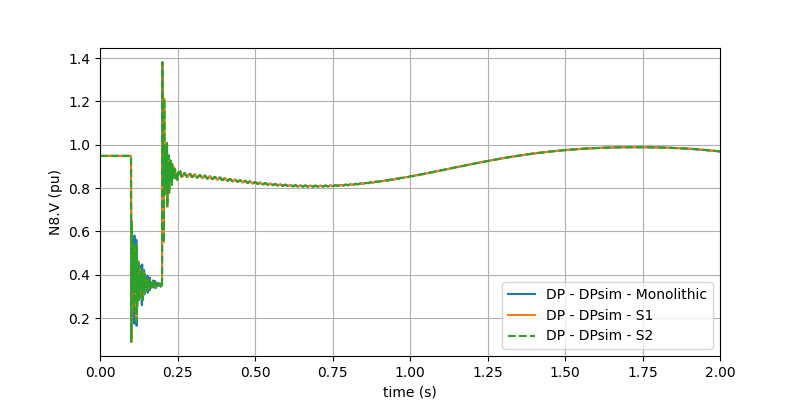

In [16]:
#"""
varname_dpsim = 'N8.V'
nominal_voltage = 230000
plot_node_volt_abs(varname_dpsim, ts_dpsim_fault_dp, ts_dpsim_fault_s1_dp, ts_dpsim_fault_s2_dp, nominal_voltage, timestep_common=1e-3)
#"""

### Plot interface current

#### Plot Results first sub topology

In [17]:
dpsim_result_file = 'logs/' + sim_name_ss_s1 + '/' + sim_name_ss_s1 + '.csv'
ts_dpsim_emt_top1 = read_timeseries_csv(dpsim_result_file)

column number: 9
results length: 20001
real column names: []
complex column names: ['N1.V', 'N2.V', 'N5.V', 'N6.V', 'N7.V', 'N8.V', 'VS_N8.I', 'VS_N8.V', 'gnd.V']


In [18]:
#mpc_reader_dyn.system

/usr/local/lib64/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 0, 'time (s)')

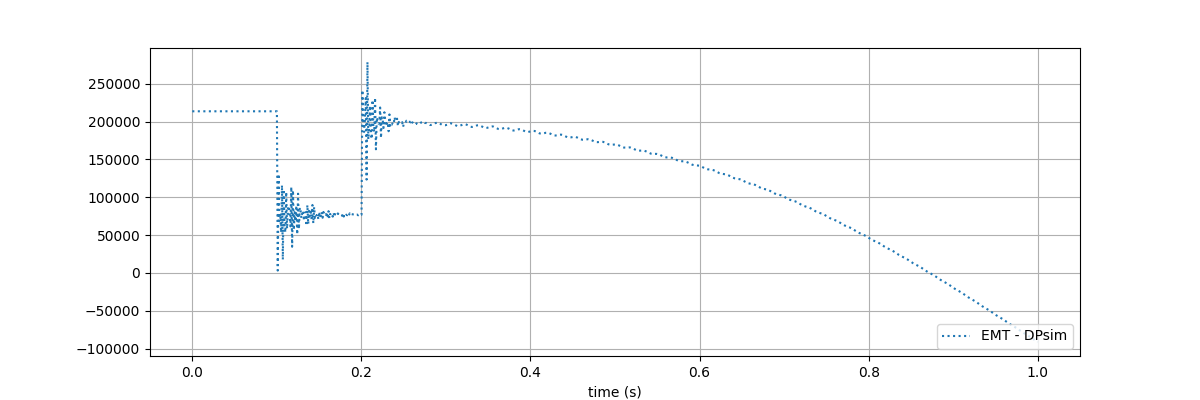

In [19]:
timestep_common = 1e-3
t_begin = 0.0
t_end = 1
begin_idx = int(t_begin/timestep_common)
end_idx= int(t_end/timestep_common)
time = np.linspace(t_begin, t_end, num=end_idx-begin_idx)

#plot parameters
width = 12
height = 4

varname_dpsim = "N8.V"
dpsim_emt_values = ts_dpsim_emt_top1[varname_dpsim].interpolate(timestep_common).values[begin_idx:end_idx]
    
plt.figure(figsize=(width, height))
#plt.subplot(1, 2, 1)
plt.plot(time, dpsim_emt_values, ':', label='EMT - DPsim')
plt.legend(loc='lower right')
plt.xlabel('time (s)')
plt.grid()
#plt.ylim([1.058, 1.062])
#plt.xlim([0.95, 1.2])
plt.xlabel("time (s)")
#plt.ylabel(varname_digSilent + " (pu)")

In [20]:
dpsim_result_file = 'logs/' + sim_name_ss_s2 + '/' + sim_name_ss_s2 + '.csv'
ts_dpsim_emt_top2 = read_timeseries_csv(dpsim_result_file)

column number: 8
results length: 20001
real column names: []
complex column names: ['CS_N8.I', 'CS_N8.V', 'N10.V', 'N11.V', 'N3.V', 'N4.V', 'N8.V', 'N9.V']


In [21]:
timestep_common = 1e-3
t_begin = 0.0
t_end = 1
begin_idx = int(t_begin/timestep_common)
end_idx= int(t_end/timestep_common)
time = np.linspace(t_begin, t_end, num=end_idx-begin_idx)

#plot parameters
width = 12
height = 4

varname_dpsim = "N8.V"
dpsim_emt_values = ts_dpsim_emt_top2[varname_dpsim+"_0"].interpolate(timestep_common).values[begin_idx:end_idx]
    
plt.figure(figsize=(width, height))
#plt.subplot(1, 2, 1)
plt.plot(time, dpsim_emt_values, ':', label='EMT - DPsim')
plt.legend(loc='lower right')
plt.xlabel('time (s)')
plt.grid()
#plt.ylim([1.058, 1.062])
#plt.xlim([0.95, 1.2])
plt.xlabel("time (s)")
#plt.ylabel(varname_digSilent + " (pu)")

KeyError: 'N8.V_0'

### 3. Dynamic Simulation with fault at node 7 (Full topology)

#### Declare some functions

In [ ]:
# def Kundur2Areas_Fault(domain="SP"):
#     if domain=="SP":
#         matpower_domain = matpower.Domain.SP
#         dpsim_domain = dpsimpy.Domain.SP
#     elif domain=="DP":
#         matpower_domain = matpower.Domain.DP
#         dpsim_domain = dpsimpy.Domain.DP
#     else:
#         domain="EMT"
#         matpower_domain = matpower.Domain.EMT
#         dpsim_domain = dpsimpy.Domain.EMT

#     sim_name_fault = domain + "_Kundur2Areas_Fault"        
#     dpsimpy.Logger.set_log_dir('logs/' + sim_name_fault)

#     mpc_reader_dyn = matpower.Reader(mpc_file_path=local_file_static, mpc_name='Kundur2Areas',
#                                      mpc_dyn_file_path=local_file_dynamic, mpc_dyn_name='Kundur2Areas_dyn')
#     mpc_reader_dyn.create_dpsim_objects(domain=matpower_domain, frequency=60, 
#                                      with_avr=False, with_tg=False, with_pss=False)

#     ### Extend topology with 3ps fault
#     sw = mpc_reader_dyn.add_3ph_faut("N7", switch_closed=1e-3, switch_open=1e18)
    
#     # create dpsim topology
#     mpc_reader_dyn.create_dpsim_topology()

#     #initialize node voltages using pf results
#     system_dyn = mpc_reader_dyn.system
#     system_dyn.init_with_powerflow(system_pf, dpsim_domain)

#     # log results
#     logger = dpsimpy.Logger(sim_name_fault)
#     for node in system_dyn.nodes:
#         logger.log_attribute(node.name()+'.V', 'v', node)
#     for gen_name in ["Gen_N1", "Gen_N2", "Gen_N3", "Gen_N3", "Gen_N4"]:
#         logger.log_attribute(gen_name+".Pe", 'Te', mpc_reader_dyn.dpsimpy_comp_dict[gen_name][0])

#     # Parametrize and run simulation
#     sim = dpsimpy.Simulation(sim_name_fault, dpsimpy.LogLevel.info)
#     sim.set_system(system_dyn)
#     if domain=="SP":
#         sim.set_time_step(1e-3)
#     else:
#         sim.set_time_step(1e-4)
#     sim.set_final_time(10)
#     sim.set_domain(dpsim_domain)
#     sim.set_solver(dpsimpy.Solver.MNA)
#     sim.set_direct_solver_implementation(dpsimpy.DirectLinearSolverImpl.KLU)
#     sim.do_init_from_nodes_and_terminals(True)
#     sim.add_logger(logger)
#     sim.do_system_matrix_recomputation(True)

#     # add events
#     sw_event_1 = dpsimpy.event.SwitchEvent(1, sw, True)
#     sw_event_2 = dpsimpy.event.SwitchEvent(1.1, sw, False)
#     sim.add_event(sw_event_1)
#     sim.add_event(sw_event_2)
#     sim.run()
    
#     return sim_name_fault

#### Dpsim Simulations

In [ ]:
# sim_name_fault_dp = Kundur2Areas_Fault(domain="DP")

In [ ]:
# sim_name_fault_emt = Kundur2Areas_Fault(domain="EMT")

### Read dynamic results

In [ ]:
# from villas.dataprocessing.timeseries import TimeSeries as ts
# import villas.dataprocessing.plottools as pt

# dpsim_result_file = 'logs/' + sim_name_fault_dp + '/' + sim_name_fault_dp + '.csv'
# ts_dpsim_dp = read_timeseries_csv(dpsim_result_file)

# dpsim_result_file = 'logs/' + sim_name_fault_emt + '/' + sim_name_fault_emt + '.csv'
# ts_dpsim_emt = read_timeseries_csv(dpsim_result_file)

### Load DigSilent Results

In [ ]:
# if not os.path.exists('Kundur2Areas-data'):
#     os.mkdir('Kundur2Areas-data')

# url = 'https://github.com/martinmoraga/dpsim_data/raw/main/Kundur2Areas/PowerFactory/DigSilent_Kundur2Areas_Fault_N7_TimeStep_100uS_EMT.csv'
# local_file = './Kundur2Areas-data/DigSilent_Kundur2Areas_Fault_N7_TimeStep_100uS_EMT.csv'
# urllib.request.urlretrieve(url, local_file)
# ts_digSilent = read_timeseries_dpsim(local_file)

### Define plot functions

In [ ]:
# timestep_common = 1e-3
# t_begin = 0.0
# t_end = 10
# begin_idx = int(t_begin/timestep_common)
# end_idx= int(t_end/timestep_common)
# time = np.linspace(t_begin, t_end, num=end_idx-begin_idx)

# #plot parameters
# width = 12
# height = 4

# def plot_node_volt_abs(varname_dpsim, varname_digSilent, 
#                        ts_dpsim_emt, ts_dpsim_dp, ts_digSilent, nominal_voltage, timestep_common=1e-3, y_lim=False):
    
#     #convert dpsim voltage to magnitude value and per-unit for comparison with psat
#     dpsim_dp_values_shifted = np.real(ts_dpsim_dp[varname_dpsim].interpolate(timestep_common).frequency_shift(60).values[begin_idx:end_idx] / nominal_voltage)
#     dpsim_emt_values = ts_dpsim_emt[varname_dpsim+"_0"].interpolate(timestep_common).values[begin_idx:end_idx] / nominal_voltage * np.sqrt(3/2)
#     digSilent_values = ts_digSilent[varname_digSilent].interpolate(timestep_common).values[begin_idx:end_idx]
    
#     plt.figure(figsize=(width, height))
#     plt.subplot(1, 2, 1)
#     plt.plot(time, dpsim_dp_values_shifted, label='DP - DPsim')
#     plt.plot(time, dpsim_emt_values, ':', label='EMT - DPsim')
#     plt.plot(time, digSilent_values, '--', label='EMT - DigSilent')
#     plt.legend(loc='lower right')
#     plt.xlabel('time (s)')
#     plt.grid()
#     #plt.ylim([1.058, 1.062])
#     plt.xlim([0.95, 1.2])
#     plt.xlabel("time (s)")
#     plt.ylabel(varname_digSilent + " (pu)")
#     if (y_lim):
#         plt.set_ylim(y_lim)
    
#     plt.subplot(1, 2, 2)
#     plt.plot(time, dpsim_dp_values_shifted, label='DP - DPsim')
#     plt.plot(time, dpsim_emt_values, ':', label='EMT - DPsim')
#     plt.plot(time, digSilent_values, '--', label='EMT - DigSilent')
#     plt.legend(loc='lower right')
#     plt.xlabel('time (s)')
#     plt.grid()
#     #plt.ylim([1.058, 1.062])
#     plt.xlim([2.9, 3.1])
#     plt.xlabel("time (s)")
#     plt.ylabel(varname_digSilent + " (pu)")
#     if (y_lim):
#         plt.ylim(y_lim)
        
#     plt.show()
    
#     #calculate RMSE
#     #rmse = np.sqrt(((dpsim_sp_values_abs_pu - psat_values) ** 2).mean())
#     #print('RMSE {:s}  = {:.6f} (pu), which is {:.3f}% of the nominal value = {:.3f} (pu) '.format(varname_dpsim, rmse, rmse/1.0*100, 1.0))
    
# def plot_elec_power(varname_dpsim, varname_digSilent, 
#                     ts_dpsim_emt, ts_dpsim_dp, ts_digSilent, timestep_common=1e-3, y_lim=False):
    
#     #convert dpsim voltage to magnitude value and per-unit for comparison with psat
#     dpsim_dp_values = ts_dpsim_dp[varname_dpsim].interpolate(timestep_common).values[begin_idx:end_idx] * 9
#     dpsim_emt_values = ts_dpsim_emt[varname_dpsim].interpolate(timestep_common).values[begin_idx:end_idx] * 9
#     digSilent_values = ts_digSilent[varname_digSilent].interpolate(timestep_common).values[begin_idx:end_idx] / 100
    
#     plt.figure(figsize=(width, height))
#     plt.plot(time, dpsim_dp_values, label='DP - DPsim')
#     plt.plot(time, dpsim_emt_values, '--', label='EMT - DPsim')
#     plt.plot(time, digSilent_values, '--', label='EMT - DigSilent')
#     plt.legend(loc='lower right')
#     plt.xlabel('time (s)')
#     plt.grid()
#     #plt.ylim([6.7, 7.1])
#     plt.xlim([t_begin, t_end])
#     plt.xlabel("time (s)")
#     plt.ylabel(varname_dpsim + " (pu)")
#     if (y_lim):
#         plt.ylim(y_lim)
#     plt.show()
    
#     #calculate RMSE
#     #rmse = np.linalg.norm(dpsim_sp_values - psat_values) / np.sqrt(len(psat_values))
#     #print('RMSE {:s}  = {:.6f} (pu), which is {:.3f}% of the nominal value = ~{:.3f} (pu) '.format(varname_dpsim, rmse, rmse/7.0*100, 7.0))

#     #return rmse

### Plot SG's electrical power

##### Gen1

In [ ]:
# varname_dpsim = 'Gen_N1.Pe'
# varname_psat = 'p_g3'
# varname_digSilent = 'G1_p'
# rmse_g1 = plot_elec_power(varname_dpsim, varname_digSilent, ts_dpsim_emt, ts_dpsim_dp, ts_digSilent, timestep_common=1e-3, y_lim=[6.25,7.25])

##### Gen2

In [ ]:
# varname_dpsim = 'Gen_N2.Pe'
# varname_digSilent = 'G2_p'
# rmse_g2 = plot_elec_power(varname_dpsim, varname_digSilent, ts_dpsim_emt, ts_dpsim_dp, ts_digSilent, timestep_common=1e-3, y_lim=[6.4,7.2])

##### Gen3

In [ ]:
# varname_dpsim = 'Gen_N3.Pe'
# varname_digSilent = 'G4_p'
# rmse_g3 = plot_elec_power(varname_dpsim, varname_digSilent, ts_dpsim_emt, ts_dpsim_dp, ts_digSilent, timestep_common=1e-3, y_lim=[5,9])

##### Gen4

In [ ]:
# varname_dpsim = 'Gen_N4.Pe'
# varname_digSilent = 'G3_p'
# rmse_g4 = plot_elec_power(varname_dpsim, varname_digSilent, ts_dpsim_emt, ts_dpsim_dp, ts_digSilent, timestep_common=1e-3, y_lim=[5.5,8.5])

### Assertion

In [ ]:
#assert(np.absolute(rmse_g1)<0.081)
#assert(np.absolute(rmse_g2)<0.094)
#assert(np.absolute(rmse_g3)<0.023)
#assert(np.absolute(rmse_g4)<0.024)

### Plot Voltages

#### LV side

In [ ]:
#"""
# varname_dpsim = 'N1.V'
# varname_digSilent = 'v1'
# nominal_voltage = 20000
# plot_node_volt_abs(varname_dpsim, varname_digSilent, ts_dpsim_emt, ts_dpsim_dp, ts_digSilent, nominal_voltage, timestep_common=1e-3)
# #"""

In [ ]:
#"""
# varname_dpsim = 'N2.V'
# varname_digSilent = 'v2'
# nominal_voltage = 20000
# plot_node_volt_abs(varname_dpsim, varname_digSilent, ts_dpsim_emt, ts_dpsim_dp, ts_digSilent, nominal_voltage, timestep_common=1e-3)
# #"""

In [ ]:
#"""
# varname_dpsim = 'N3.V'
# varname_digSilent = 'v3'
# nominal_voltage = 20000
# plot_node_volt_abs(varname_dpsim, varname_digSilent, ts_dpsim_emt, ts_dpsim_dp, ts_digSilent, nominal_voltage, timestep_common=1e-3)
# #"""

In [ ]:
#"""
# varname_dpsim = 'N4.V'
# varname_digSilent = 'v4'
# nominal_voltage = 20000
# plot_node_volt_abs(varname_dpsim, varname_digSilent, ts_dpsim_emt, ts_dpsim_dp, ts_digSilent, nominal_voltage, timestep_common=1e-3)
# #"""

#### Low voltage side

In [ ]:
#"""
# varname_dpsim = 'N5.V'
# varname_digSilent = 'v5'
# nominal_voltage = 230000
# plot_node_volt_abs(varname_dpsim, varname_digSilent, ts_dpsim_emt, ts_dpsim_dp, ts_digSilent, nominal_voltage, timestep_common=1e-3)
# #"""


In [ ]:
#"""
# varname_dpsim = 'N6.V'
# varname_digSilent = 'v6'
# nominal_voltage = 230000
# plot_node_volt_abs(varname_dpsim, varname_digSilent, ts_dpsim_emt, ts_dpsim_dp, ts_digSilent, nominal_voltage, timestep_common=1e-3)
# #"""

In [ ]:
#"""
# varname_dpsim = 'N7.V'
# varname_digSilent = 'v7'
# nominal_voltage = 230000
# plot_node_volt_abs(varname_dpsim, varname_digSilent, ts_dpsim_emt, ts_dpsim_dp, ts_digSilent, nominal_voltage, timestep_common=1e-3)
# #"""

In [ ]:
#"""
# varname_dpsim = 'N8.V'
# varname_digSilent = 'v8'
# nominal_voltage = 230000
# plot_node_volt_abs(varname_dpsim, varname_digSilent, ts_dpsim_emt, ts_dpsim_dp, ts_digSilent, nominal_voltage, timestep_common=1e-3)
# #"""

In [ ]:
#"""
# varname_dpsim = 'N9.V'
# varname_digSilent = 'v9'
# nominal_voltage = 230000
# plot_node_volt_abs(varname_dpsim, varname_digSilent, ts_dpsim_emt, ts_dpsim_dp, ts_digSilent, nominal_voltage, timestep_common=1e-3)
# #"""

In [ ]:
#"""
# varname_dpsim = 'N10.V'
# varname_digSilent = 'v10'
# nominal_voltage = 230000
# plot_node_volt_abs(varname_dpsim, varname_digSilent, ts_dpsim_emt, ts_dpsim_dp, ts_digSilent, nominal_voltage, timestep_common=1e-3)
# #"""

In [ ]:
#"""
# varname_dpsim = 'N11.V'
# varname_digSilent = 'v11'
# nominal_voltage = 230000
# plot_node_volt_abs(varname_dpsim, varname_digSilent, ts_dpsim_emt, ts_dpsim_dp, ts_digSilent, nominal_voltage, timestep_common=1e-3)
# #"""